# Introducing using transformers for Pictures
In this notebook we're working with `BEIT` model

## 1. Importing

In [1]:
!pip install -q datasets
!pip install -q transformers
!pip install -q evaluate
!pip install -q pytorch-lightning
!pip install -q torchmetrics

In [2]:
import torch
import random
import evaluate
import numpy as np
import torch.nn as nn
from tqdm import tqdm
import pytorch_lightning as pl
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import transforms
from torchvision import datasets as tv_dataset
from torch.utils.data import Dataset, DataLoader, random_split
from transformers import (
    BeitImageProcessor,
    BeitForSemanticSegmentation,
    AutoImageProcessor,
    BeitForImageClassification,
    TrainingArguments,
    Trainer
)
from torchmetrics.functional.classification import (
    multiclass_accuracy
)
from datasets import load_dataset, load_metric
device = torch.device(0).type

## 2. Training model for Semantic Segmentation

### I. Load the model and dataset

In [ ]:
model = BeitForSemanticSegmentation.from_pretrained("microsoft/beit-base-finetuned-ade-640-640").to(device)
DS = load_dataset("scene_parse_150")

  0%|          | 0/3 [00:00<?, ?it/s]

### II. Preprocess Data


In [ ]:
image_processor = AutoImageProcessor.from_pretrained("microsoft/beit-base-finetuned-ade-640-640")

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


In [ ]:
def preprocess_images(examples):

    images = examples['image']
    # images = [np.array(image, dtype=np.uint8) for image in images]
    # images = [np.moveaxis(image, source=-1, destination=0) for image in images]
    inputs = image_processor(images=images)
    examples['pixel_values'] = inputs['pixel_values']

    return examples

In [ ]:
train_dataset = DS["train"].map(preprocess_images, batched=True, batch_size=64)
test_dataset = DS["test"].map(preprocess_images, batched=True, batch_size=64)
validation_dataset = DS["validation"].map(preprocess_images, batched=True, batch_size=64)

### III. Train
**Do to time of training this model we don't train this part but the code can be seen here**

In [ ]:
training_args = TrainingArguments(output_dir="test_trainer", evaluation_strategy="epoch")

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=DS["train"],
    eval_dataset=DS["test"],
)

In [ ]:
trainer.train()

### IV. Inference
In this section we choose three images and get semantic segmentation of it from `BEiT` 

#### First Image 

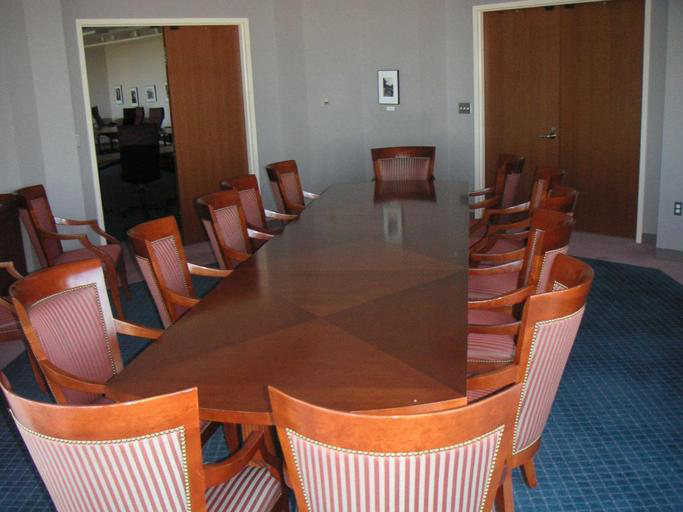

In [ ]:
i = random.randint(0, len(DS["train"]))
# original image
DS["train"][i]["image"]

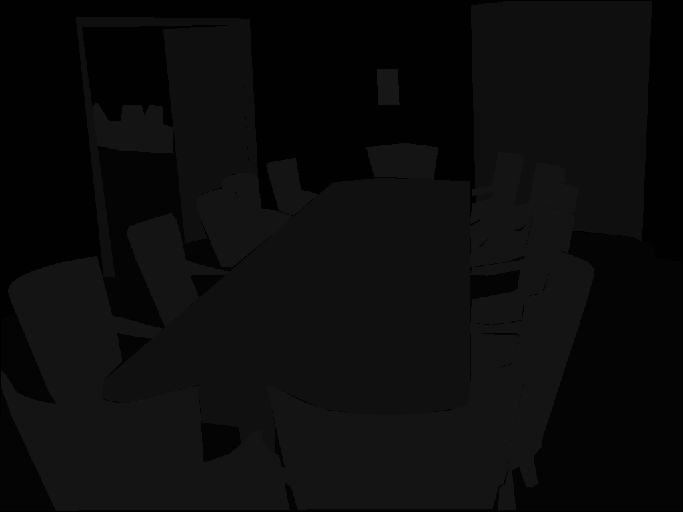

In [ ]:
DS["train"][i]["annotation"]

In [ ]:
with torch.no_grad():
  inputs = image_processor(DS["train"][i]["image"], return_tesors="pt")
  inputs = np.expand_dims(inputs.pixel_values[0], axis=0)
  inputs = torch.tensor(inputs).to(device)
  output = model(inputs)

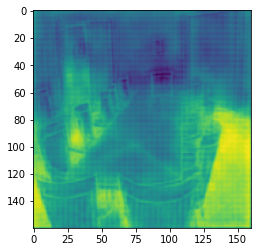

In [ ]:
plt.imshow(output.logits[0][3].cpu())

#### Second Image 

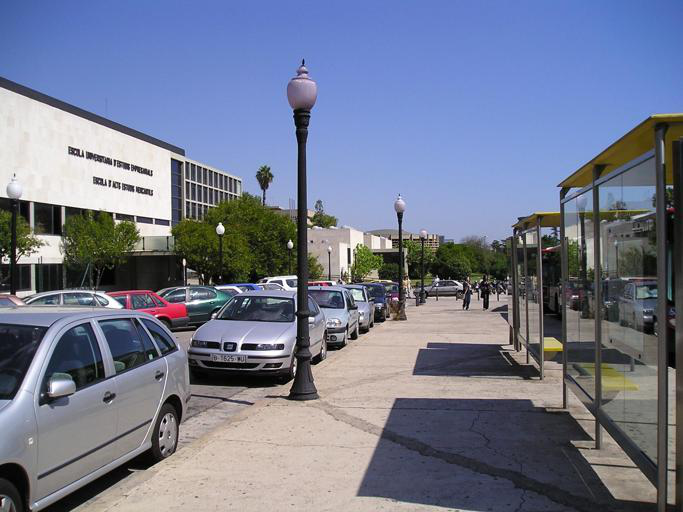

In [ ]:
i = random.randint(0, len(DS["train"]))
# original image
DS["train"][i]["image"]

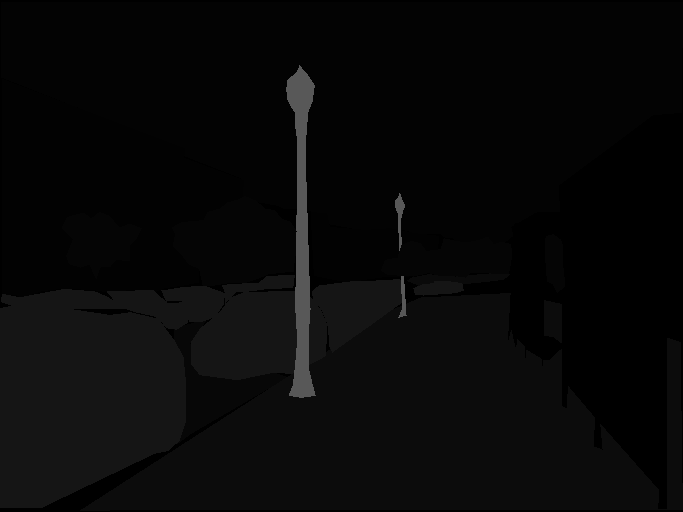

In [ ]:
DS["train"][i]["annotation"]

In [ ]:
with torch.no_grad():
  inputs = image_processor(DS["train"][i]["image"], return_tesors="pt")
  inputs = np.expand_dims(inputs.pixel_values[0], axis=0)
  inputs = torch.tensor(inputs).to(device)
  output = model(inputs)

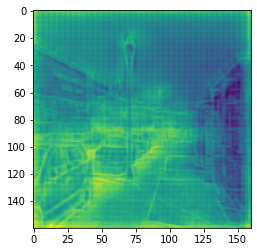

In [ ]:
plt.imshow(output.logits[0][3].cpu())

#### Third Image 

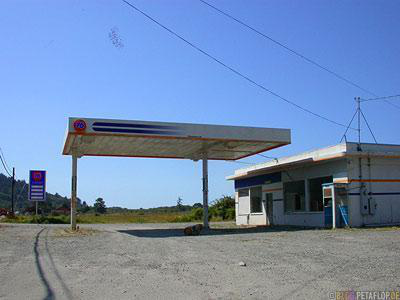

In [ ]:
i = random.randint(0, len(DS["train"]))
# original image
DS["train"][i]["image"]

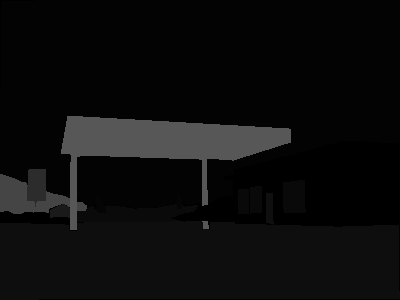

In [ ]:
DS["train"][i]["annotation"]

In [ ]:
with torch.no_grad():
  inputs = image_processor(DS["train"][i]["image"], return_tesors="pt")
  inputs = np.expand_dims(inputs.pixel_values[0], axis=0)
  inputs = torch.tensor(inputs).to(device)
  output = model(inputs)

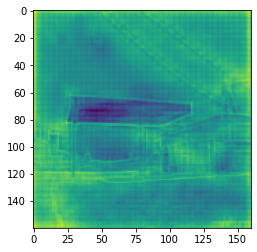

In [ ]:
plt.imshow(output.logits[0][3].cpu())

## 3. Training model for Classification problem

### I. Load the model and dataset

First loading `CIFAR` dataset

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

In [5]:
DS_cifar = load_dataset("cifar10")
cifar_train_val = tv_dataset.CIFAR10(root="./datasets", download=True, transform=transform, train=True)
cifar_test = tv_dataset.CIFAR10(root="./datasets", download=True, transform=transform, train=False)

  0%|          | 0/2 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified


Now build two models:
1. A simple MLP model
2. BEit model that has an MLP on top

In [6]:
class MLP(pl.LightningModule):
  def __init__(self):
    super().__init__()
    self.fc1 = nn.Linear(32*32*3, 1024)
    self.fc2 = nn.Linear(1024, 510)
    self.fc3 = nn.Linear(510, 10)
  
  def forward(self, x: torch.Tensor):
    x = torch.flatten(x, start_dim=1)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x

  def configure_optimizers(self):
    optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
    return optimizer

  def training_step(self, train_batch, batch_idx):
    x, y = train_batch
    x = x.to(device)
    y = y.to(device)
    preds = self.forward(x)
    loss = F.cross_entropy(preds, y)
    self.log('train_loss', loss)
    return loss

  def validation_step(self, val_batch, batch_idx):
    x, y = val_batch
    x = x.to(device)
    y = y.to(device)
    preds = self.forward(x)
    loss = F.cross_entropy(preds, y)
    val_accuracy = multiclass_accuracy(preds, y, 10)
    self.log("validation accuracy", val_accuracy, prog_bar=True,
             on_step=False, on_epoch=True)
    return loss

In [41]:
class BEIT(pl.LightningModule):
  def __init__(self, num_labels=10):
    super(BEIT, self).__init__()
    self.beit = BeitForImageClassification.from_pretrained("microsoft/beit-base-patch16-224")
    self.classifier = nn.Linear(1000, num_labels)
    self.num_labels = num_labels

  def forward(self, x):
    with torch.no_grad():
      x = self.beit(x).logits     # do not want to train the beit model

    x = self.classifier(x)
    return x

  def configure_optimizers(self):
    optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
    return optimizer

  def training_step(self, train_batch, batch_idx):
    x, y = train_batch
    x = x.to(device)
    y = y.to(device)
    preds = self.forward(x)
    loss = F.cross_entropy(preds, y)
    self.log('train_loss', loss)
    return loss

  def validation_step(self, val_batch, batch_idx):
    x, y = val_batch
    x = x.to(device)
    y = y.to(device)
    preds = self.forward(x)
    loss = F.cross_entropy(preds, y)
    val_accuracy = multiclass_accuracy(preds, y, 10)
    self.log("validation accuracy", val_accuracy, prog_bar=True,
             on_step=True, on_epoch=True)
    return loss

### II. Preprocess

In [8]:
cifar_train, cifar_val = random_split(cifar_train_val, [45000, 5000])

In [9]:
feature_extractor = BeitImageProcessor.from_pretrained("microsoft/beit-base-patch16-224")

In [10]:
train_ds = DS_cifar["train"]
test_ds = DS_cifar["test"]

In [11]:
def preprocess_images(examples):

    images = examples['img']
    images = [np.array(image, dtype=np.uint8) for image in images]
    images = [np.moveaxis(image, source=-1, destination=0) for image in images]
    inputs = feature_extractor(images=images)
    examples['pixel_values'] = inputs['pixel_values']

    return examples

In [21]:
preprocessed_train_ds = train_ds.map(preprocess_images, batched=True, num_proc=4)
preprocessed_test_ds = test_ds.map(preprocess_images, batched=True, num_proc=4)

In [26]:
DS_train, DS_val = random_split(preprocessed_train_ds, [45000, 5000])

### III. Train

#### 1. first model

In [58]:
train_loader = DataLoader(cifar_train, batch_size = 512)
val_loader = DataLoader(cifar_val, batch_size = 512)
test_loader = DataLoader(cifar_test, batch_size = 512)

In [56]:
mlp_model = MLP()
mlp_model.to(device)

MLP(
  (fc1): Linear(in_features=3072, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=510, bias=True)
  (fc3): Linear(in_features=510, out_features=10, bias=True)
)

In [57]:
trainer_mlp = pl.Trainer(gpus=1, precision=16, max_epochs=30)
trainer_mlp.fit(mlp_model, train_loader, val_loader)

/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:441: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
INFO:pytorch_lightning.utilities.rank_zero:Using 16bit native Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name | Type   | Params
--------------------------------
0 | fc1  | Linear | 3.1 M 
1 | fc2  | Linear | 522 K 
2 | fc3  | Linear | 5.1 K 
-------------

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=30` reached.


#### 2. second model

In [32]:
class CustomDataset(Dataset):
  def __init__(self, dataset):
    self.dataset = dataset

  def __getitem__(self, idx):
    x = torch.tensor(self.dataset[idx]["pixel_values"])
    y = torch.tensor(self.dataset[idx]["label"])

    return x, y

  def __len__(self):
    return len(self.dataset)

In [105]:
train_dataset = CustomDataset(DS_train)
val_dataset = CustomDataset(DS_val)
test_dataset = CustomDataset(preprocessed_test_ds)

In [112]:
train_loader = DataLoader(train_dataset, batch_size = 256)
val_loader = DataLoader(val_dataset, batch_size = 256)
test_loader = DataLoader(test_dataset, batch_size = 256)

Loading the model

In [42]:
beit_model = BEIT()
beit_model.to(device)

BEIT(
  (beit): BeitForImageClassification(
    (beit): BeitModel(
      (embeddings): BeitEmbeddings(
        (patch_embeddings): BeitPatchEmbeddings(
          (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
        )
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (encoder): BeitEncoder(
        (layer): ModuleList(
          (0): BeitLayer(
            (attention): BeitAttention(
              (attention): BeitSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=False)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.0, inplace=False)
                (relative_position_bias): BeitRelativePositionBias()
              )
              (output): BeitSelfOutput(
                (dense): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.

In [45]:
trainer = pl.Trainer(gpus=1, precision=16, max_epochs=30)
trainer.fit(beit_model, train_loader, val_loader)

INFO:pytorch_lightning.utilities.rank_zero:Using 16bit native Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name       | Type                       | Params
----------------------------------------------------------
0 | beit       | BeitForImageClassification | 86.5 M
1 | classifier | Linear                     | 10.0 K
----------------------------------------------------------
86.5 M    Trainable params
0         Non-trainable params
86.5 M    Total params
173.082   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

### IV. Test

#### Test on first model

In [103]:
corrects = 0
for i in range(len(cifar_test)):
  pred = mlp_model(cifar_test[i][0].unsqueeze(0))
  if torch.argmax(pred).item() == cifar_test[i][1]:
    corrects += 1
  
accuracy = 100 * corrects / len(cifar_test)
print(f"The accuracy of MLP model is {accuracy:.3f} %")

The accuracy of MLP model is 51.060 %


#### Test on second model

In [146]:
total = len(preprocessed_test_ds)
corrects = 0
for i, (x, y) in enumerate(test_loader):
  x = x.to(device)
  y = y.to(device)
  preds = beit_model(x)
  preds_labels = torch.argmax(preds, axis=1)
  corrects += torch.sum(preds_labels == y).item()

accuracy = 100 * corrects / total
print(f"The Accuracy of fine tuned BEIT model is {accuracy:.3f} %")

The Accuracy of fine tuned BEIT model is 96.250 %
